### Poisson-Gleichung 2D

<p>$-\frac{\partial^2u}{\partial x^2} - \frac{\partial^2u}{\partial y^2}=1$</p>

#### Verständnisaufgaben
<p>1.: Netzarchitektur beschreiben</p>
<p>2.: Wo finde ich im Internet die Befehle der DeepXDE-Bibliothek und kann mir Hilfe holen?</p>
<p>3.: Mit welchem Befehl wird der Bibliothek die Differentialgleichung und die Randbedingungen übergeben?</p>
<p>4.: Warum wurden keine Initialbedingungen definiert?</p>
<p>5.: Welche Randbedingung wurde definiert?</p>
<p>6.: Warum würde es Sinn ergeben, den L-BFGS-B Optimierer nachzuschalten?</p>
<p>7.: Wozu wird der Befehl "glorot uniform" verwendet?</p>

#### Anwendungsaufgaben (One factor at a time)
<p>Beantworten Sie uns jeweils, was sich geändert hat.</p>
<p>Nach jedem Durchlauf einen Screenshot des Trainingsverlaufs und des Plots machen.</p>
<p>Nach jeder Änderung wieder in den Ursprungszustand zurück setzen.</p>
<p>0.: Kommentieren Sie den Code aus: Welche Zeile/ Funktion erfüllt welchen Zweck? (Plot-Funktion ausgenommen)</p>
<p>1.: Gleichung ändern: 1. In Summe soll unsere Gleichung nun 5 sein.</p>
<p>2.: Randbedingungen ändern: Setzen Sie die RB u = 1.</p>
<p>3.: Netzarchitektur ändern: 1 Hidden-Layer mit 8 Neuronen.</p>
<p>4.: Anzahl Epochen ändern: Stellen Sie 15.000 Epochen ein.</p>
<p>5.: Ersten Optimierer ändern: Stochastic Gradient Descent 'sgd'</p>
<p>6.: Aktivierungsfunktion ändern: Zu ReLU 'relu'</p>

Compiling model...
Building feed-forward neural network...
'build' took 0.065183 s

'compile' took 0.510725 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.00e+00, 5.73e-01]    [1.00e+00, 5.73e-01]    []  
1000      [1.43e-02, 6.51e-03]    [1.61e-02, 6.51e-03]    []  
2000      [2.05e-03, 2.83e-03]    [2.17e-03, 2.83e-03]    []  
3000      [4.49e-04, 1.90e-03]    [4.56e-04, 1.90e-03]    []  

Best model at step 3000:
  train loss: 2.35e-03
  test loss: 2.36e-03
  test metric: []

'train' took 6.698754 s

Saving loss history to /Users/lennartfuhrig/Desktop/Lenny/Uni/Master/1. Semester/SDS/InvertedPendulum/PINN/loss.dat ...
Saving training data to /Users/lennartfuhrig/Desktop/Lenny/Uni/Master/1. Semester/SDS/InvertedPendulum/PINN/train.dat ...
Saving test data to /Users/lennartfuhrig/Desktop/Lenny/Uni/Master/1. Semester/SDS/InvertedPendulum/PINN/test.dat ...


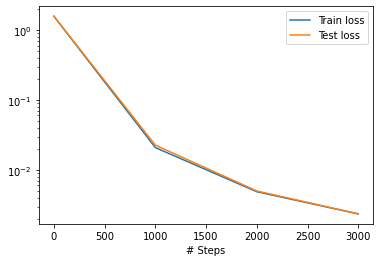

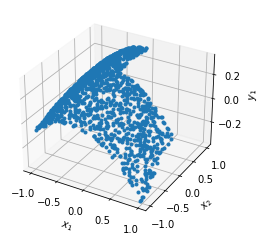

In [6]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    return -dy_xx - dy_yy - 1

# return np.isclose(x[0], -1) or np.isclose(x[0], 1)
# If the point x (the first argument) is on the entire boundary of the geometry
# (the left and right endpoints of the interval in this case), then on_boundary is True,
# otherwise, on_boundary is False. Thus, we can also define boundary in a simpler way
def boundary(_, on_boundary):
    return on_boundary


geom = dde.geometry.Polygon([[0, 0], [1, 0], [1, -1], [-1, -1], [-1, 1], [0, 1]])
bc = dde.DirichletBC(geom, lambda x: 0, boundary)

data = dde.data.PDE(geom, pde, bc, num_domain=1200, num_boundary=0, num_test=1500)
net = dde.maps.FNN([2] + [16] * 3 + [1], "sigmoid", "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=3000)
#model.compile("L-BFGS-B")
#losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

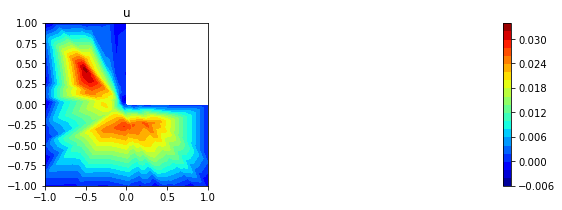

In [2]:
###################################
# plot function
###################################



import matplotlib.pyplot as plt
import numpy as np

def dde_plot_2D(geom, x_max, x_min, y_max, y_min, model, stepsize = 0.1):
    X = np.arange(x_min, x_max+stepsize, stepsize) # [0 1 2 3 4 5]
    Y = np.arange(y_min, y_max+stepsize, stepsize) # [0 1]    
    XX, YY = np.meshgrid(X, Y) # [0 1 2 3 4 5], [0 1] --> [[0 1 2 3 4 5], [0 1 2 3 4 5]], [[0 0 0 0 0 0], [1 1 1 1 1 1]]
    
    # np.ravel(XX): [[0 1 2 3 4 5], [0 1 2 3 4 5]] --> [0 1 2 3 4 5 0 1 2 3 4 5]
    ravelXX = np.ravel(XX)
    ravelYY = np.ravel(YY)

    # np.vstack(ravelXX, ravelYY): [[0 1 2 3 4 5 0 1 2 3 4 5], [0 0 0 0 0 0 1 1 1 1 1 1]]
    vStack = np.vstack((ravelXX, ravelYY))

    # transpose: [[0 1 2 3 4 5 0 1 2 3 4 5], [0 0 0 0 0 0 1 1 1 1 1 1]] --> [[0 0],[1 0],...,[3 1],[4 1],[5 1]]
    vStackT = vStack.T

    pred = model.predict(vStackT)

    # to set all points outside the geom np.nan, get all indices, where outside
    logical_in_geom = geom.inside(vStackT)
    #a[start:stop:step] for multidimension use , for nested array --> a[:, 0] all elements first array, first value inner
    u_pred = np.where(logical_in_geom, pred[:, 0], np.nan)
    
    u = u_pred.reshape((len(Y), len(X)))

    var_dict = {'u': u}
    for item in var_dict:
        plt.figure(figsize=(15, 3))
        plt.contourf(var_dict[item], levels=20, extent=[x_min, x_max, y_min, y_max], cmap='jet')
        plt.title(item)
        plt.colorbar()
        plt.axis('image') # scale
        plt.show()
    
    
dde_plot_2D(geom, 1, -1, 1, -1, model, stepsize=0.01)